# Risk-free rates

I found some strange behavior when working with Heston around the risk-free rate, so I backed up and examined the concept alone. In the same manner that the volatility can be implied from an option price given the risk-free rate, the risk-free rate can be implied given the volatility. In attempting to get the risk-free rate, I saw wildly varying values. I would have expected something fairly consistent. Perhaps this data was fudged for this exercise (to avoid breach of contract with Bloomberg) or fabricated entirely. Or otherwise, I'm missing something.

## Define pricing function

In [4]:
import numpy as np
from scipy.stats import norm

def bs_call(S, X, T, r, sigma):
    sig_sqrt_t = sigma * np.sqrt(T)
    d1 = (np.log(S/X) + (r+sigma*sigma/2)*T)/sig_sqrt_t
    d2 = d1 - sig_sqrt_t
    opt_val = S * norm.cdf(d1) - X * np.exp(-r*T) * norm.cdf(d2)
    return opt_val

print(bs_call(60, 65, 0.25, 0.08, 0.3))

2.1333684449162007


## Verify that the function is monotonic

And therefore has only one zero

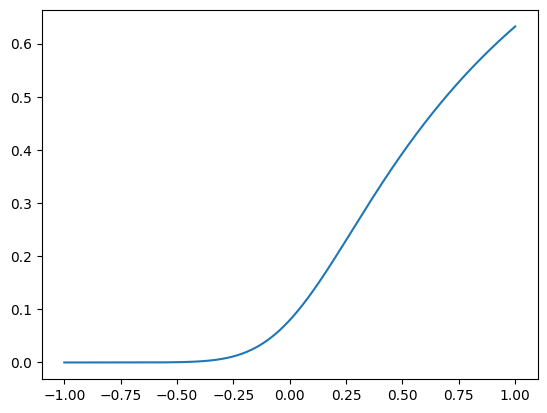

In [11]:
import matplotlib.pyplot as plt

rates = np.linspace(-1.0, 1.0, 1000)
call_values = bs_call(1, 1, 1, rates, 0.2)

plt.plot(rates, call_values)

## Import data

In [12]:
import os
import pandas as pd
import datetime as dt

raw_data = pd.read_csv(os.path.join('/mnt/c/Users/Steve/implied_vol_machine_learning', 'options_20220824.csv'))
call_data = raw_data.loc[(raw_data["Type"] == "call") & (raw_data["Ask"] < 99000.0)].copy()
call_data.loc[:, "moneyness"] = call_data["Strike"] / call_data["UnderlyingPrice"]
call_data.loc[:, "implied_vol"] = call_data["IV"]
call_data.loc[:, "maturity"] = (pd.to_datetime(call_data["Expiration"]) - pd.to_datetime(call_data[" DataDate"])).dt.days / 365
call_data.loc[:, "ticker"] = call_data["UnderlyingSymbol"]
call_data.loc[:, "Mid"] = (call_data["Bid"]+call_data["Ask"])/2

In [34]:
tesla_data = call_data.loc[call_data['ticker'] == 'TSLA']
focus_data = tesla_data.loc[tesla_data['maturity'] == tesla_data['maturity'].median()].copy()

## Solve for the risk-free rate

And observe the wildly varying values ('Mid' is best, but still kind of bad)

In [33]:
from scipy.optimize import root

def solve_for_r(solve_params, S, X, T, implied_vol, opt_price):
    r = solve_params[0]
    return bs_call(S, X, T, r, implied_vol) - opt_price

price_types = ['Bid', 'Ask', 'Mid']
for count, (call_idx, call_opt) in enumerate(focus_data.iterrows()):
    risk_free_rates = {}
    for price_type in price_types:
        res = root(solve_for_r, [0.0], args=(call_opt['UnderlyingPrice'], call_opt['Strike'], call_opt['maturity'], call_opt['implied_vol'], call_opt[price_type]))
        if res.success:
            risk_free_rates[price_type] = res.x[0]
    print(f'Risk free rates: index={call_idx}, {risk_free_rates}')
    if count > 5:
        break

Risk free rates: index=1235718, {'Bid': -0.15932502474175886, 'Ask': 0.28034347464541043, 'Mid': 0.05488455344462904}
Risk free rates: index=1235720, {'Bid': -0.06773948951056515, 'Ask': 0.13788427766394148, 'Mid': 0.03384172989886915}
Risk free rates: index=1235722, {'Bid': -0.03110350163090737, 'Ask': 0.12076420992123132, 'Mid': 0.044159199005478426}
Risk free rates: index=1235724, {'Bid': -0.01819394320815128, 'Ask': 0.10328376981456285, 'Mid': 0.042116849875004345}
Risk free rates: index=1235726, {'Bid': -0.018154762171711688, 'Ask': 0.06379315979169033, 'Mid': 0.02264744483869132}
Risk free rates: index=1235728, {'Bid': -0.015735640548608675, 'Ask': 0.06561040656586675, 'Mid': 0.02477424789273057}
Risk free rates: index=1235730, {'Bid': -0.0151857829866626, 'Ask': 0.056059850659978906, 'Mid': 0.020320929181579767}
